In this notebook, we compares our results with the two previously-used test scenarios
    
* growth of a mono-disperse particle distribution, where only the Brownian motions between the same sized dust are considered (see Appendix B in [Birnstiel+2010](https://ui.adsabs.harvard.edu/abs/2010A%26A...513A..79B/abstract))


* the steady-state dust distribution under a typical disk environment (see [Birnstiel+2011](https://ui.adsabs.harvard.edu/abs/2011A%26A...525A..11B/abstract))

---
PS: The results of solving the Smoluchowski equation numerically are known to depend on resolution, initial setup, and the length of time step (and also the `Python` environment and the machine used). It is thus normal if you get slightly different results. If you get qualitatively different results, be sure to test different setups.

# Import Modules

In [1]:
from astropy import units as u
from astropy import constants as c
import numpy as np
import scipy as sp
import mpmath as mp
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib nbagg
np.set_printoptions(edgeitems=5, linewidth=180, precision=6)
mp.mp.dps = 25

In [3]:
from rubble import Rubble, RubbleData

In [4]:
dt_1d = 86400; dt_1yr = dt_1d * 365.25

# Growth of a mono-disperse particle distribution with only the Brownian motions

In [5]:
# First, do a small-scale quick test

r = Rubble(76, 1e-4, 1e-2, 0, 0.18, 
           delta_dist=1e-4,  # initialized with a monodisperse distribution
           coag2nearest=True, # put coagulation mass into the bin nearest to the mass sum
           Sigma_g=18, T=196, H=932972501049.1309,
           run_name='coagBM', );

# the following line sets sets dv(i!=j) = 0
r._user_setup(test='BMonly')

In [6]:
r.run(1e4, 5.0, 5.0, no_burnin=True)

In [7]:
# construct analytical solution (see Birnstiel+2010)
cgs_k_B = c.k_B.to(u.g*u.cm**2/u.s**2/u.K).value
rho_d = 0.18 / (np.sqrt(2*np.pi) * 932972501049.1309)
fac = np.sqrt(12 * cgs_k_B * 196 / 1.6)
analy_a = lambda t, t0, a0, T = 196 : (2.5 * rho_d / (1.6 * np.pi) * np.sqrt(12 * cgs_k_B * T / 1.6) * (t - t0)*(u.yr.to(u.s)) + a0**2.5)**0.4

<IPython.core.display.Javascript object>


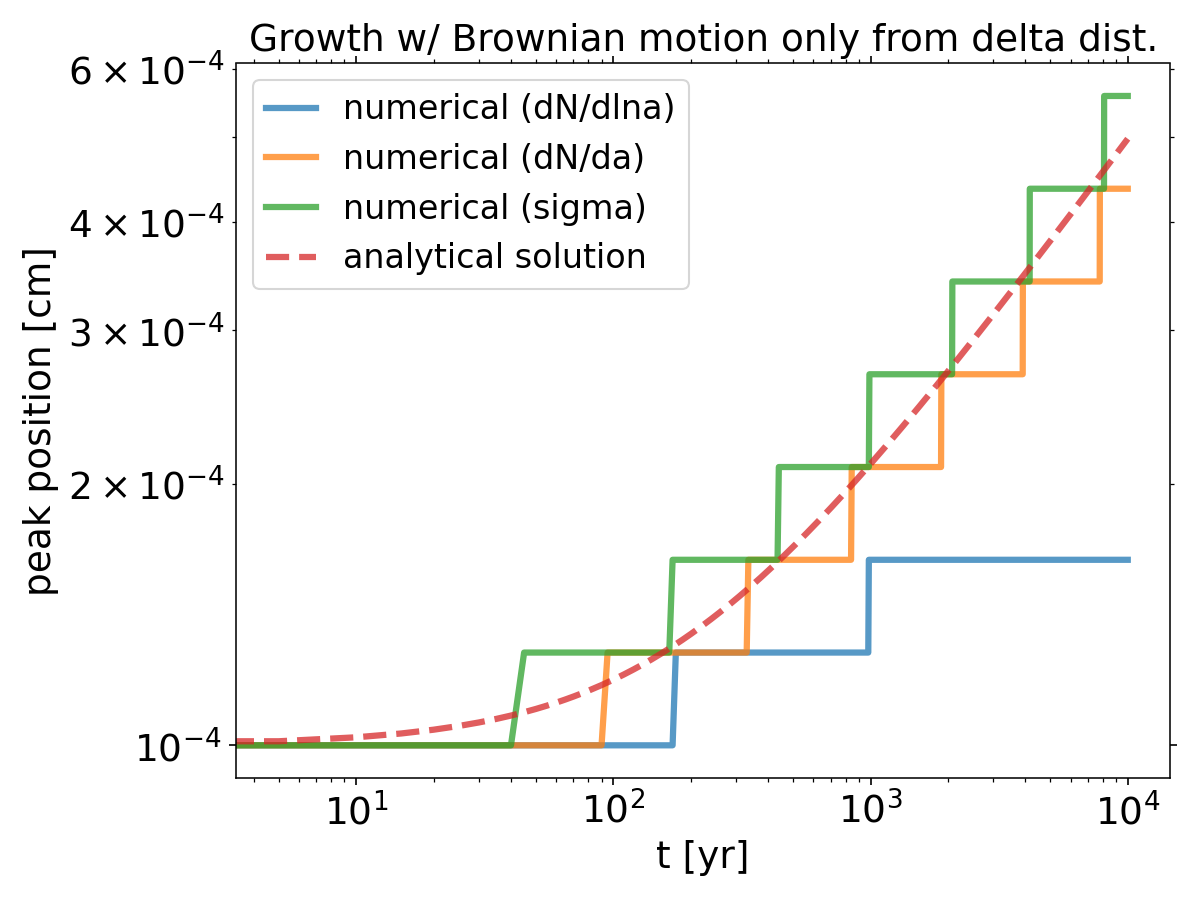

In [10]:
rd = RubbleData("coagBM.dat")
fig, ax = rd.plot_peak_pos()
ax.loglog(rd.t, analy_a(rd.t, 0, rd.a[1]), '--', lw=3, alpha=0.75, label='analytical solution')
ax.set(title='Growth w/ Brownian motion only from delta dist.')
ax.legend(loc='best'); fig.tight_layout()

### Now, for a larger-scale longer test

In [13]:
r = Rubble(132, 1e-4, 1e-2, 0, 0.18, 
           delta_dist=1e-4, coag2nearest=True, # put coagulation mass into the bin nearest to the mass sum
           Sigma_g=18, T=196, H=932972501049.1309,
           run_name='coagBM_longer');

# the following line sets sets dv(i!=j) = 0
r._user_setup(test='BMonly')

In [42]:
# N.B., this run may cost hours, better put in on HPC
r.run(1e6, 5.0, 10.0, no_burnin=True)

<IPython.core.display.Javascript object>


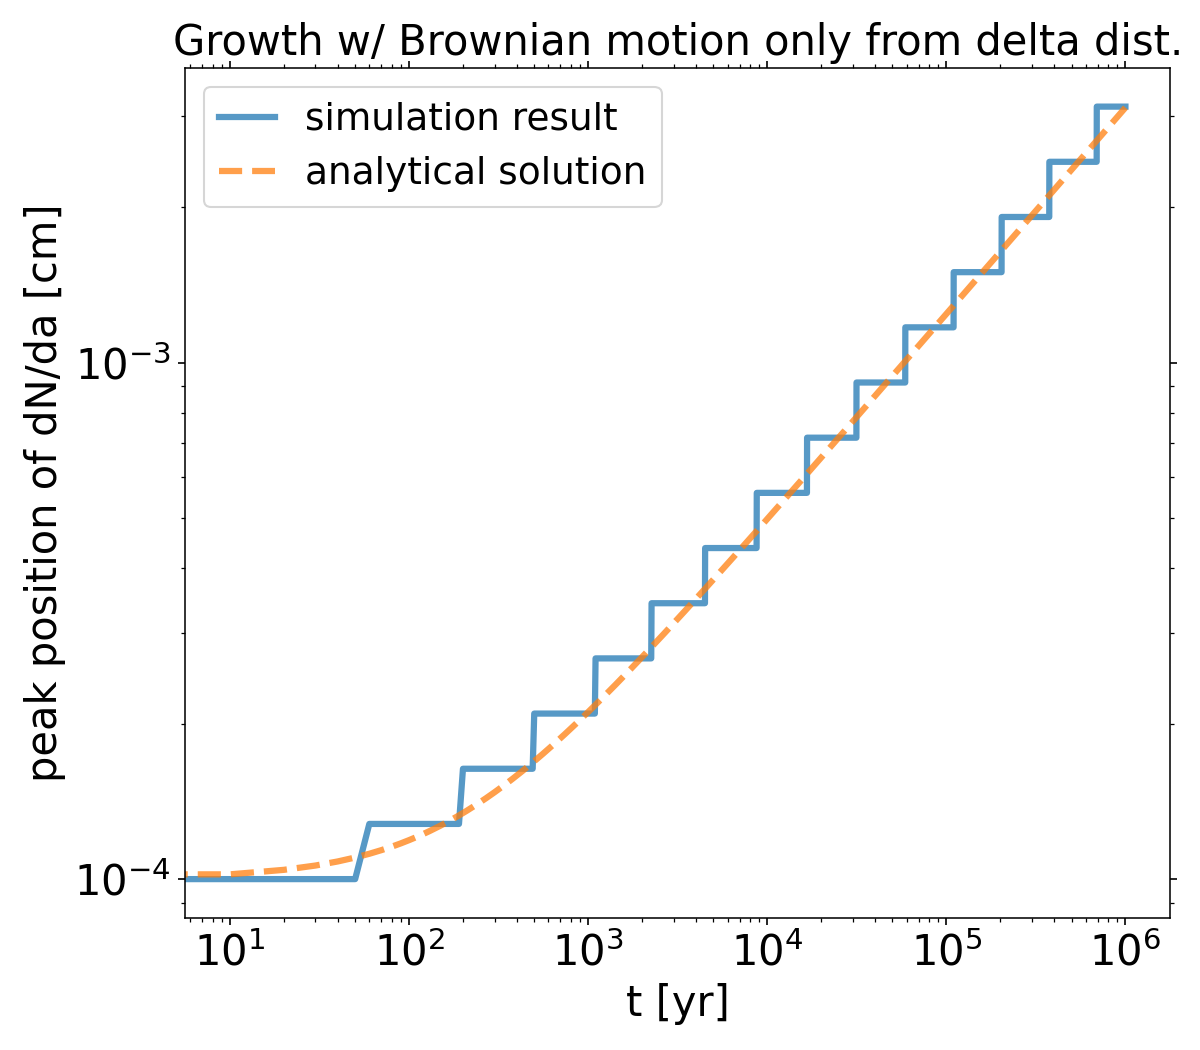

In [17]:
rd = RubbleData("coagBM_longer.dat")
fig, ax = plt.subplots(figsize=(8, 7))
ax.loglog(rd.t, rd.peak_dNda, lw=3, alpha=0.75, label='simulation result')
ax.loglog(rd.t, analy_a(rd.t, 0, rd.a[1]), '--', lw=3, alpha=0.75, label='analytical solution')
ax.set(xlabel=r't [yr]', ylabel=r'peak position of dN/da [cm]', title='Growth w/ Brownian motion only from delta dist.');
ax.legend(loc='best'); fig.tight_layout()

# Steady-state dust distribution under a typical disk environment

In [6]:
r = Rubble(190, 2.5e-6, 1e0, 3.5, 0.2, 
           ranged_dist=[1e-5, 1e-3],
           Sigma_g=20, T=50, alpha=1e-4, H=932972501049.1309, 
           coag2nearest=True,
           run_name='ss_test')
r.vel_dist_flag = False
r.bouncing_flag = False
r.mass_transfer_flag = False

In [8]:
# we can check what flags are on 
# here we include both coagulation and fragmentation with Epstein+Stokes regime and with a static kernel
r.show_flags()

frag_flag:                       True
bouncing_flag:                   False
mass_transfer_flag:              False
f_mod_flag:                      False
vel_dist_flag:                   False
simple_St_flag:                  False
full_St_flag:                    False
feedback_flag:                   False
uni_gz_flag:                     False
closed_box_flag:                 True
dyn_env_flag:                    False
static_kernel_flag:              True
debug_flag:                      False
flag_activated:                  True


In [9]:
# simply run a few hundred years
r.run(1000, 1, 1, no_burnin=True)

In [10]:
# calcualte characteristic size following Birnstiel+2011
alpha = 1e-4
c_s = np.sqrt(r.cgs_k_B * 50 / r.cgs_mu)
Re = alpha * 20 * 2e-15 / (2 * r.cgs_mu)
a_BT = (8*20/(np.pi*1.6) * Re**(-0.25) * np.sqrt(r.cgs_mu / (3*np.pi*alpha))*(4*np.pi/3*1.6)**(-0.5))**0.4
a_max = 2*20/(np.pi*alpha*1.6) * 100**2/c_s**2
a_sett = 2 * alpha * 20 / (np.pi*1.6)
a_St1 = 2 * 20 / (np.pi * 1.6)
a_12 = 1/1.6 * 2*20 / (np.pi*1.6) * Re**(-0.5)

0.09174480524449942 2.335067716924337e-06


<IPython.core.display.Javascript object>


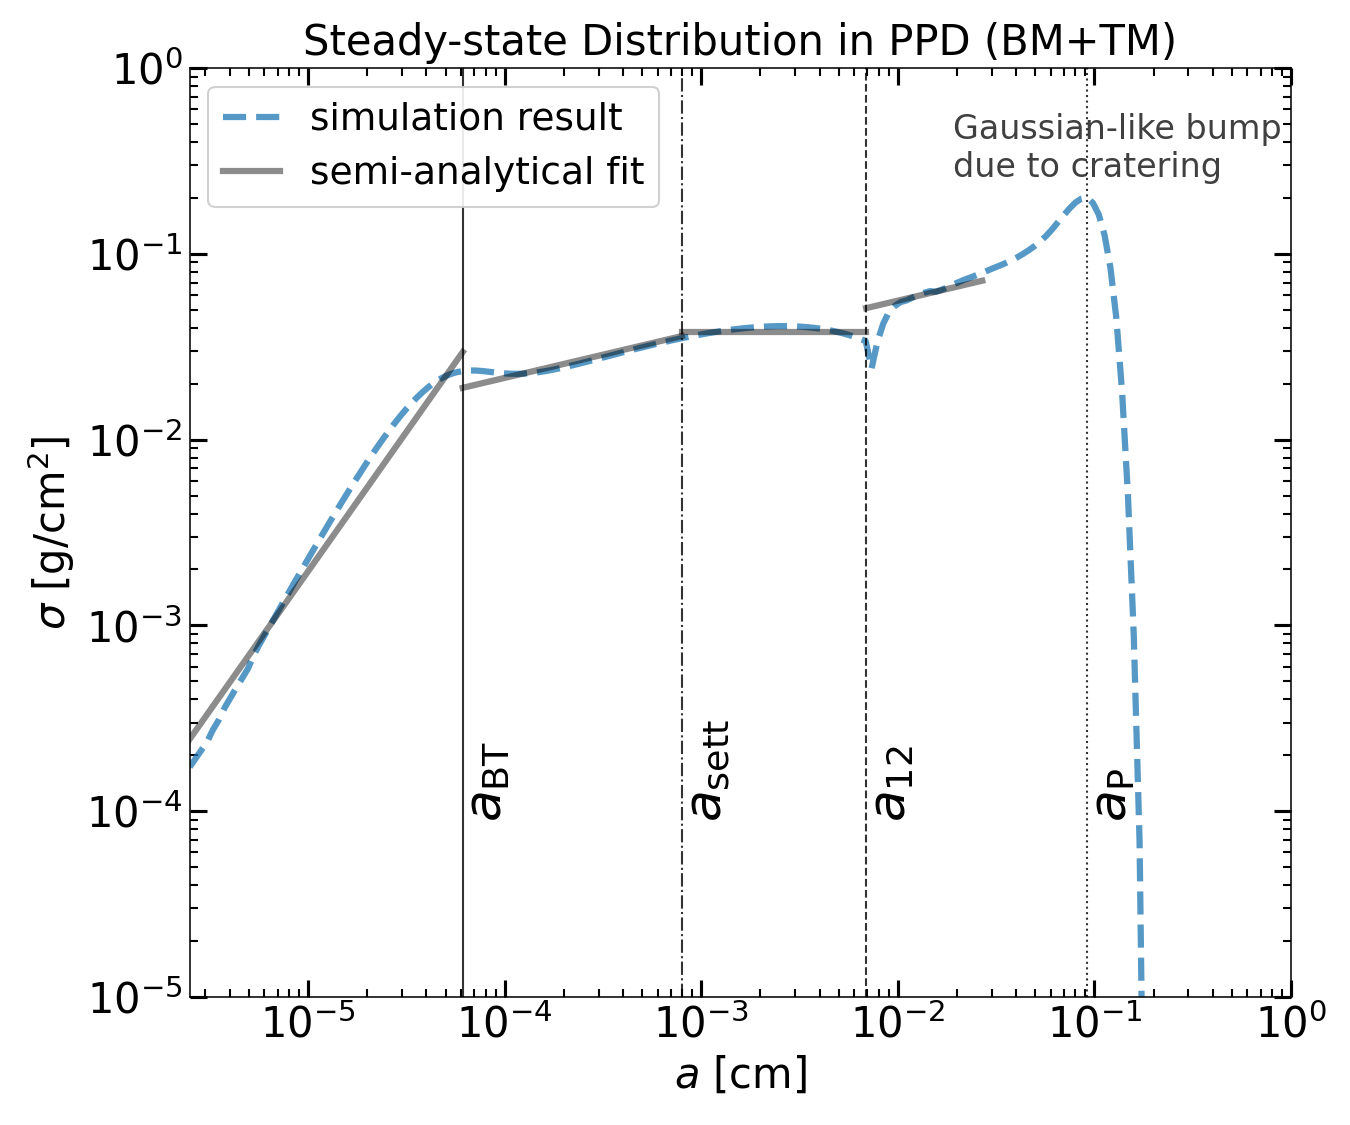

In [19]:
print(r.a[r.sigma.argmax()], r.a[(r.a*r.Na).argmax()])
fig, ax = plt.subplots(figsize=(9, 7.5))
ax.loglog(r.a[1:-1], r.sigma[1:-1], '--', lw=3, alpha=0.75, label='simulation result');
a_P = r.a[np.argmax(r.sigma)]; a_inc = r.a[np.argmin(abs(r.a-0.3*a_P))]

ax.axvline(x=a_BT, color='k',alpha=0.8); ax.text(a_BT,1e-4,r'$a_{\rm BT}$', rotation=90, fontsize=25);
ax.axvline(x=a_sett, ls='-.', color='k',alpha=0.8); ax.text(a_sett,1e-4,r'$a_{\rm sett}$', rotation=90, fontsize=25); 
ax.axvline(x=a_12, ls='--', color='k',alpha=0.8); ax.text(a_12,1e-4,r'$a_{\rm 12}$', rotation=90, fontsize=25);
ax.axvline(x=a_P, ls=':', color='k',alpha=0.8); ax.text(a_P,1e-4,r'$a_{\rm P}$', rotation=90, fontsize=25); 
ax.text(0.019, 0.26,'Gaussian-like bump\ndue to cratering', alpha=0.75, fontsize=16)

base_y = 1.75e-4; ax.loglog([2e-6, a_BT], [base_y, base_y*((a_BT/2e-6)**(1.5))], 'k', lw=3, alpha=0.45, label=r'semi-analytical fit')
base_y = 0.019; ax.loglog([a_BT, a_sett], [base_y, base_y*((a_sett/a_BT)**(0.25))], 'k', lw=3, alpha=0.45)
base_y = 0.038; ax.loglog([a_sett, a_12], [base_y, base_y*((a_sett/a_BT)**(0.0))], 'k', lw=3, alpha=0.45)
base_y = 0.051; ax.loglog([a_12, a_inc], [base_y, base_y*((a_inc/a_12)**(0.25))], 'k', lw=3, alpha=0.45)

ax.set(xlim=[2.5e-6, 1.0], ylim=[1e-5, 1], ylabel=r"$\sigma$ [g/cm$^2$]", xlabel=r"$a$ [cm]", title=r"Steady-state Distribution in PPD (BM+TM)")
ax.legend(loc='upper left', framealpha=0.9); fig.tight_layout();